In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.arima.model import ARIMA

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark")  

In [2]:
# get the data 

!wget -nc https://lazyprogrammer.me/course_files/timeseries/us_macro_quarterly.xlsx

--2024-04-14 00:42:37--  https://lazyprogrammer.me/course_files/timeseries/us_macro_quarterly.xlsx
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76805 (75K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: 'us_macro_quarterly.xlsx'

us_macro_quarterly. 100%[===================>]  75.00K  --.-KB/s    in 0.001s  

2024-04-14 00:42:38 (53.6 MB/s) - 'us_macro_quarterly.xlsx' saved [76805/76805]



In [3]:
df = pd.read_excel('us_macro_quarterly.xlsx')

df.head()

/opt/anaconda3/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  228 non-null    object 
 1   GDPC96      228 non-null    float64
 2   JAPAN_IP    227 non-null    float64
 3   PCECTPI     228 non-null    float64
 4   GS10        228 non-null    float64
 5   GS1         228 non-null    float64
 6   TB3MS       228 non-null    float64
 7   UNRATE      228 non-null    float64
 8   EXUSUK      220 non-null    float64
 9   CPIAUCSL    228 non-null    float64
dtypes: float64(9), object(1)
memory usage: 17.9+ KB


In [9]:
# Unnamed column represent the date which is given in quarterlery intervals 

def custom_parser(date): # note that input will be an dtype of object as in the df 

    year, quarter = date.split(':')

    month = (int(quarter)-1) * 3 + 1 # map quarter 1 to Jan (as the beginning month of that quarter), quarter 2 is mapped to April and so on... 

    new_date = f"{year}-{month}"

    return datetime.strptime(new_date, '%Y-%m')

In [10]:
df['Date'] = df['Unnamed: 0'].apply(custom_parser)

In [11]:
df.head()

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL,Date
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667,1957-01-01
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333,1957-04-01
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333,1957-07-01
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000,1957-10-01
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667,1958-01-01


In [12]:
df.set_index('Date', inplace=True)

In [15]:
df.drop('Unnamed: 0', axis = 1, inplace =True)

df.head()

,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
Date,,,,,,,,,
1957-01-01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1957-04-01,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
1957-07-01,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
1957-10-01,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
1958-01-01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


In [16]:
# set frequency 

df.index.freq = 'QS'

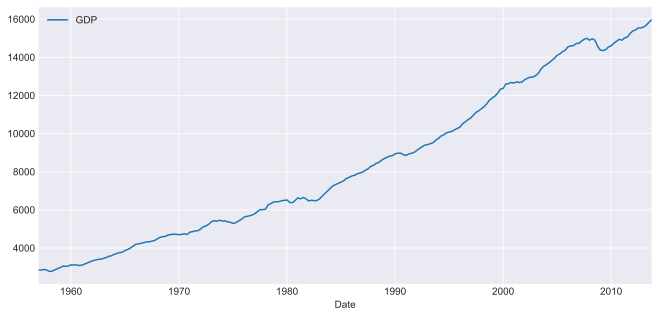

In [18]:
# GDP: Gross Domestic Product --> Total market value of goods and services produced within a country in a given time period

fig, axes =  plt.subplots(figsize = (11,5))

df['GDPC96'].plot(ax = axes, label = 'GDP')

axes.grid()
axes.legend()

In [19]:
# GDP growth 

df['GDPGrowth'] = np.log(df['GDPC96']).diff()

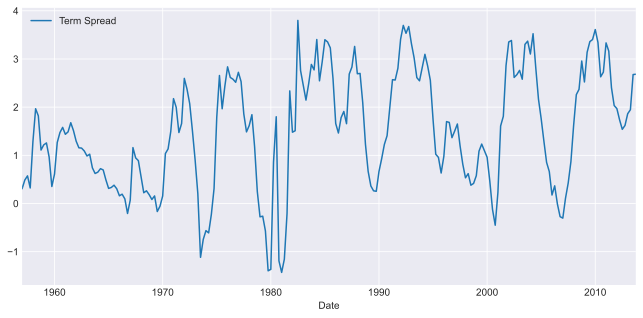

In [20]:
# Term Spread: there are multiple kinds of 'spread', we are discussing specifically terms spread 
# term spread = long term int. rate - short term int. rate
# short term investments have a lower interest rate than long term investments!

df['TSpread'] = df['GS10'] - df['TB3MS']

fig, axes =  plt.subplots(figsize = (11,5))

df['TSpread'].plot(ax = axes, label = 'Term Spread')

axes.grid()
axes.legend()

In [48]:
cols = ['GDPGrowth', 'TSpread'] # we did not differences Term Spreat but we could as well, it seems ok given the plot above 

df1 = df[cols][1:].copy() # ignore the first row as we differenced the the gdp column to get te gdpgrowth 

In [49]:
# train - test 

Ntest = 12

train, test = df1[:-Ntest].copy(), df1[-Ntest:].copy()

train_idx, test_idx = df1.index <= train.index[-1], df1.index > train.index[-1]

In [51]:
# scale the both time series
scaler = StandardScaler()

train[["GDPGrowth_S","TSpread_S"]] = scaler.fit_transform(train)
test[["GDPGrowth_S","TSpread_S"]] = scaler.transform(test)

In [58]:
# add the scaled data into the original dataframe as well 

new_cols = train.columns.tolist()[-2:]

df1.loc[train_idx, new_cols] = train[new_cols].copy()
df1.loc[test_idx,new_cols] = test[new_cols].copy()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


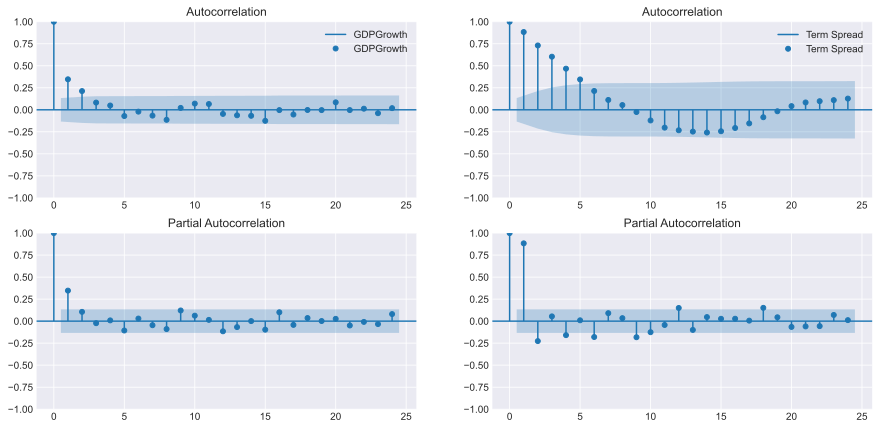

In [61]:
fig, axes = plt.subplots(2,2, figsize = (15,7))

plot_acf(train['GDPGrowth_S'], ax = axes[0,0], label = 'GDPGrowth')
plot_acf(train["TSpread_S"], ax = axes[0,1], label = 'Term Spread')

plot_pacf(train['GDPGrowth_S'], ax = axes[1,0])
plot_pacf(train["TSpread_S"], ax = axes[1,1])

for i in range(2):
    for j in range(2):
        axes[i,j].grid()
        axes[i,j].legend()



In [62]:
adfuller(train['GDPGrowth_S']) # small p value, GDPGrowth is stationary

(-7.446639654625673,
 5.814896580910741e-11,
 1,
 213,
 {'1%': -3.461429147102264,
  '5%': -2.875206950587861,
  '10%': -2.5740544497344002},
 512.854231063742)

In [63]:
adfuller(train['TSpread_S']) # small p value, TSpread is stationary

(-4.001020795475581,
 0.001405175490749354,
 12,
 202,
 {'1%': -3.4631437906252636,
  '5%': -2.8759570379821047,
  '10%': -2.574454682874228},
 246.3694988421874)

In [65]:
p, q = 18, 1

t0 = datetime.now()

model = VARMAX(train[new_cols], order = (p,q))
res = model.fit(maxiter = 100)
print('Duration:', datetime.now()-t0)

/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           81     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64746D+00    |proj g|=  5.79231D-01


 This problem is unconstrained.



At iterate    5    f=  1.62085D+00    |proj g|=  1.77252D-01

At iterate   10    f=  1.61868D+00    |proj g|=  1.83062D-02

At iterate   15    f=  1.61823D+00    |proj g|=  2.51773D-02

At iterate   20    f=  1.61785D+00    |proj g|=  7.64951D-03

At iterate   25    f=  1.61741D+00    |proj g|=  6.85301D-03

At iterate   30    f=  1.61648D+00    |proj g|=  1.02740D-02

At iterate   35    f=  1.61530D+00    |proj g|=  6.18343D-02

At iterate   40    f=  1.61462D+00    |proj g|=  3.21488D-02

At iterate   45    f=  1.61436D+00    |proj g|=  5.16171D-03

At iterate   50    f=  1.61428D+00    |proj g|=  4.09917D-03

At iterate   55    f=  1.61425D+00    |proj g|=  3.62734D-03

At iterate   60    f=  1.61423D+00    |proj g|=  1.86682D-03

At iterate   65    f=  1.61423D+00    |proj g|=  1.64384D-03

At iterate   70    f=  1.61423D+00    |proj g|=  1.70024D-03

At iterate   75    f=  1.61422D+00    |proj g|=  4.13860D-03

At iterate   80    f=  1.61422D+00    |proj g|=  3.42257D-03

At iter

/opt/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 0:00:28.327746


In [72]:
# get fitted values and forecasts for the test set 

train_pred = res.fittedvalues
fcast = res.get_forecast(Ntest)
test_pred = fcast.predicted_mean 

In [75]:
train_pred.head()

,GDPGrowth_S,TSpread_S
Date,,
1957-04-01,-0.002500,0.037039
1957-07-01,-0.494856,-0.603382
1957-10-01,-0.208635,-0.567928
1958-01-01,-0.615495,-0.745621
1958-04-01,-1.634360,0.497674


In [82]:
# insert them into the df1 

df1.loc[train_idx, 'Trainp_GDPGrowth'] = train_pred['GDPGrowth_S']
df1.loc[test_idx, 'Testp_GDPGrowth'] = test_pred['GDPGrowth_S']

df1.loc[train_idx, 'Trainp_TSpread'] = train_pred['TSpread_S']
df1.loc[test_idx, 'Testp_TSpread'] = test_pred['TSpread_S']

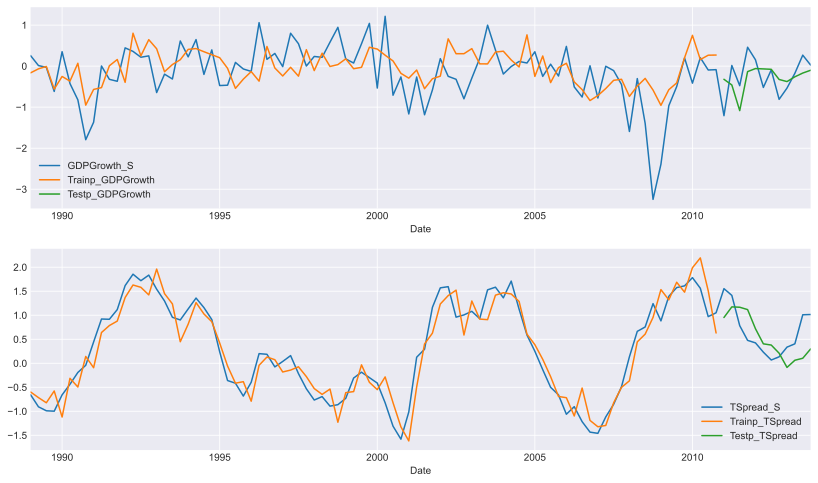

In [85]:
# plot both series and predictions 

fig, axes = plt.subplots(2,1,figsize = (14,8))

GDP_cols = ['GDPGrowth_S', 'Trainp_GDPGrowth', 'Testp_GDPGrowth']
TS_cols = ['TSpread_S', 'Trainp_TSpread', 'Testp_TSpread']

df1.iloc[-100:][GDP_cols].plot(ax = axes[0])
df1.iloc[-100:][TS_cols].plot(ax = axes[1])

for i in range(2):
    axes[i].grid()


For GDP growth, model is having trouble understanding the extreme values and it does not seem to do well in the test set either! For TS spread it seems to do better at least in the training set!  

In [87]:
cols

['GDPGrowth', 'TSpread']

In [89]:
for col in cols:

    y_true = df1.loc[train_idx, f"{col}_S"]
    y_pred = res.fittedvalues[f"{col}_S"]
    print(f"Training R^2 for {col}: {r2_score(y_true,y_pred):.3f}")

    y_test_true = df1.loc[test_idx, f"{col}_S"]
    y_test_pred = fcast.predicted_mean[f"{col}_S"]
    print(f"Test R^2 for {col}: {r2_score(y_test_true,y_test_pred):.3f}")

Training R^2 for GDPGrowth: 0.276
Test R^2 for GDPGrowth: 0.035
Training R^2 for TSpread: 0.874
Test R^2 for TSpread: -0.046


Train and test $R^2$ is low for GDPGrowth as expected from the plots! While Train $R^2$ is large for Term Spread, its test counterpart is pretty low and negative! 

### Compare with BASELINE ARIMA
-------

In [90]:
train.head()

,GDPGrowth,TSpread,GDPGrowth_S,TSpread_S
Date,,,,
1957-04-01,-0.002220,0.486667,-1.094132,-0.804627
1957-07-01,0.009693,0.573333,0.219378,-0.732834
1957-10-01,-0.010303,0.323333,-1.985286,-0.939930
1958-01-01,-0.026265,1.283333,-3.745106,-0.144679
1958-04-01,0.006577,1.966667,-0.124216,0.421386


In [92]:
for col in cols: 

    arima = ARIMA(train[f"{col}_S"], order = (p,0,q))
    res = arima.fit()
    fcast = res.get_forecast(Ntest)
    y_train = df1.loc[train_idx, f"{col}_S"]
    y_test = df1.loc[test_idx, f"{col}_S"]
    
    print(f"{col} Train R^2, {r2_score(y_train, res.fittedvalues):.3f}")
    print(f"{col} Test R^2, {r2_score(y_test, fcast.predicted_mean):.3f}")

GDPGrowth Train R^2, 0.206
GDPGrowth Test R^2, -0.849
TSpread Train R^2, 0.833
TSpread Test R^2, -2.996


We can see that Baseline ARIMA does worse than the VARMA on both train and test set! So we can say that VARMA model which assumes some correlation between two time series has some predictive value! 